In [2]:
! conda install -c conda-forge folium --yes
! pip install emoji --upgrade
! pip install geocoder

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.10.0              |             py_0          59 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be INSTAL

In [12]:
# standard weapons of choice
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

# webscraping weapons of choice for standard HTMl sites
import requests
from bs4 import BeautifulSoup

# geolocation helper
import geocoder # module to convert an address into latitude and longitude values

# all the viz
import matplotlib.pyplot as plt
import folium
from tabulate import tabulate
import emoji

%matplotlib inline

##  <center>🍁 Toronto Neighborhood Exploration 🍁</center>

#### <center>Let's explore some neighborhoods in Toronto, Ontario Canada, cluster them together, and then find cool stuff in these neighborhoods by using the FourSquare API</center>
Let's get some data in here by scraping what we need from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [4]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup= BeautifulSoup(response.content, 'lxml')
toronto_table = soup.find_all('table')[0]
toronto_df = pd.read_html(str(toronto_table))[0]
toronto_df

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


#### Lets get rid all the postcodes that don't have boroughs assciated wtih them. 📬

In [5]:
toronto_df = toronto_df[toronto_df['Borough'] != 'Not assigned']
toronto_df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


#### Let's collapse all of the neighborhoods into their corresponding boroughs and postcode so they appear on in a single row (neighborhoods belong to boroughs belong to postcodes)

In [6]:
toronto_df = toronto_df.groupby(['Postcode','Borough'], sort=False).agg(lambda x: ', '.join(x))
toronto_df.reset_index(level=['Postcode', 'Borough'], inplace=True)
toronto_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Not assigned


#### Some of the neighborhoods are not assigned.  If that is the case, let's add the name of its borough as the name of the neighborhood.

In [7]:
toronto_df['Neighbourhood'].replace('Not assigned', toronto_df['Borough'], inplace=True)
toronto_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


#### Our final table now looks like this:

In [8]:
print(tabulate(toronto_df, headers=toronto_df.columns, tablefmt='fancy grid'))

     Postcode    Borough           Neighbourhood
---  ----------  ----------------  --------------------------------------------------------------------------------------------------------------------------------------
  0  M3A         North York        Parkwoods
  1  M4A         North York        Victoria Village
  2  M5A         Downtown Toronto  Harbourfront, Regent Park
  3  M6A         North York        Lawrence Heights, Lawrence Manor
  4  M7A         Queen's Park      Queen's Park
  5  M9A         Etobicoke         Islington Avenue
  6  M1B         Scarborough       Rouge, Malvern
  7  M3B         North York        Don Mills North
  8  M4B         East York         Woodbine Gardens, Parkview Hill
  9  M5B         Downtown Toronto  Ryerson, Garden District
 10  M6B         North York        Glencairn
 11  M9B         Etobicoke         Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
 12  M1C         Scarborough       Highland Creek, Rouge Hill, Port Union
 1

In [9]:
toronto_df.shape

(103, 3)

#### Now that everything is cleaned up, let's get the longitude and latitude values associated with each postcode 🌐

In [10]:
for i, postcode in enumerate(toronto_df['Postcode']):
    address = f'{postcode}, Toronto, Ontario'
    location = geocoder.arcgis(address)
    toronto_df.at[i, 'Latitude'] = location.latlng[0]
    toronto_df.at[i, 'Longitude'] = location.latlng[1]

In [11]:
toronto_df.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752440,-79.329271
1,M4A,North York,Victoria Village,43.730421,-79.313320
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.655120,-79.362640
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.723125,-79.451589
4,M7A,Queen's Park,Queen's Park,43.661102,-79.391035
5,M9A,Etobicoke,Islington Avenue,43.662242,-79.528379
6,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
7,M3B,North York,Don Mills North,43.749195,-79.361905
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.707535,-79.311773
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657363,-79.378180


#### Great!  Now that we have some lat, long values, let's see how these boroughs cluster together. 🏙️

It is my initial hypothesis that because the postcode is where the longitude and latitude are assigned (and everything else is a subset of the postcode in this order: Postcode &rarr; Borough &rarr; Neighborhood), the number of postcodes should be the optimal k for our k-Means clustering algorithm.

In [117]:
# Scale the feature values down.  The only features we have is latitude and longitude, so let's use that.
X = StandardScaler().fit_transform(toronto_df[['Latitude', 'Longitude']])
X[0:10,:]

array([[ 0.90851765,  0.70083687],
       [ 0.4884243 ,  0.87126864],
       [-0.94818337,  0.34429198],
       [ 0.34923703, -0.60612216],
       [-0.83405124,  0.04089232],
       [-0.81230382, -1.42661095],
       [ 2.03575953,  2.1299786 ],
       [ 0.84660854,  0.35213875],
       [ 0.05180619,  0.887795  ],
       [-0.90539051,  0.1782466 ]])

In [118]:
# Since the neighborhoods are catagorical, let's encode them so they're easier for the model to digest (ints instead of strings)
y = toronto_df['Borough'].replace(toronto_df['Borough'].unique(), np.arange(len(toronto_df['Borough'].unique())))
y = y.values
y[0:10]

array([0, 0, 1, 0, 2, 3, 4, 0, 5, 1])

In [119]:
# Initializing the model with my hypothesis set that there are 11 clusters (because there are 11 neighborhoods)
k_means = KMeans(n_clusters=len(toronto_df['Borough'].unique()), init='k-means++', n_init=15, max_iter=500)

# Fitting the model to the feature set
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
    n_clusters=11, n_init=15, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [120]:
# Let's append the labels to our dataset
toronto_df['Label'] = k_means.labels_
toronto_df.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Label
0,M3A,North York,Parkwoods,43.752440,-79.329271,5
1,M4A,North York,Victoria Village,43.730421,-79.313320,5
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.655120,-79.362640,7
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.723125,-79.451589,3
4,M7A,Queen's Park,Queen's Park,43.661102,-79.391035,7
5,M9A,Etobicoke,Islington Avenue,43.662242,-79.528379,6
6,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517,2
7,M3B,North York,Don Mills North,43.749195,-79.361905,10
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.707535,-79.311773,0
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657363,-79.378180,7


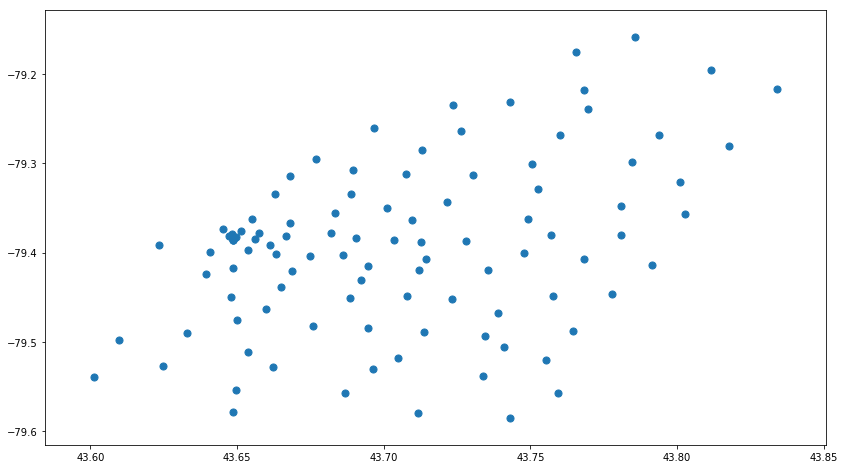

In [130]:
# Visualizing the raw lat, long combos
plt.figure(figsize=(14, 8))
plt.scatter(x=toronto_df['Latitude'], y=toronto_df['Longitude'], s=50)
plt.show()

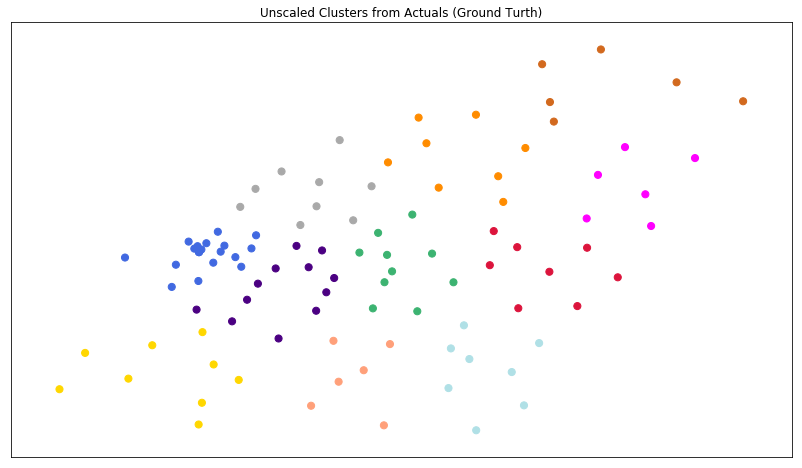

In [133]:
# Visualizing how the actual neighborhoods cluster
colors = np.array(['darkgray', 'lightsalmon', 'chocolate', 'mediumseagreen', 'indigo', 'darkorange', 'gold', 'royalblue', 'powderblue', 'magenta', 'crimson'])

fig = plt.figure(figsize=(14, 8))
ax2 = fig.add_subplot(1, 1, 1)
plt.scatter(x=toronto_df['Latitude'], y=toronto_df['Longitude'], c=colors[toronto_df['Label']], s=50)

ax2.set_title('Unscaled Clusters from Actuals (Ground Turth)')
ax2.set_xticks(())
ax2.set_yticks(())
plt.show()

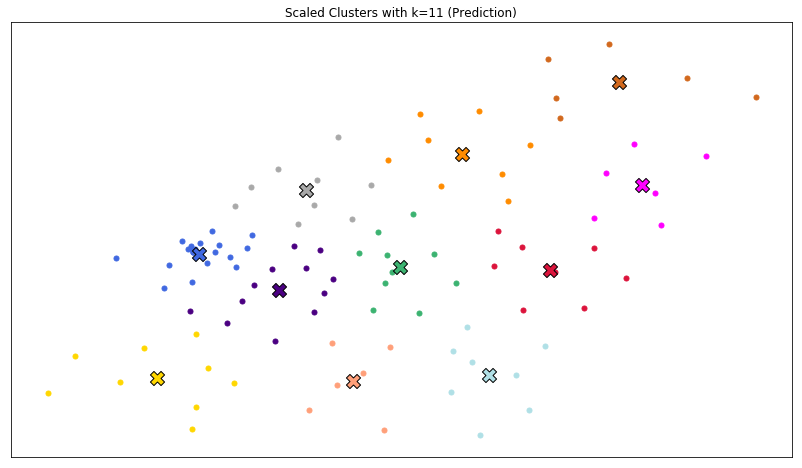

In [136]:
# Visualizing what the unsupervized clusters look like
fig = plt.figure(figsize=(14, 8))

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(len(k_means.cluster_centers_)), colors):
    my_members = (k_means.labels_ == k)
    cluster_center = k_means.cluster_centers_[k]
    ax.scatter(X[my_members, 0], X[my_members, 1], c=colors[k], marker='.', s=100)
    ax.scatter(cluster_center[0], cluster_center[1], c=colors[k], marker='X', edgecolor='k', s=200)

ax.set_title('Scaled Clusters with k=11 (Prediction)')
ax.set_xticks(())
ax.set_yticks(())
plt.show()

In [138]:
# Did our clustering do a good job?  Let's take a look at the confusion matrix to find out
print(classification_report(y_true=toronto_df['Label'], y_pred=k_means.labels_))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00        21
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103



Alright!  Looking pretty good!  We have 11 Toronto Neighborhoods, and we've properly clustered them.  Now, let's explore the city a bit using the Four Square API.  Let's find a good place to enjoy a nice cup of coffee while we study data science.